In [1]:
# Importing the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import nltk
import re

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("training.csv")
test_data = pd.read_csv("test_apr.csv")
validation_data = pd.read_csv("validation_apr.csv")

In [3]:
print("Train data :\n",train_data.head(),"\n")
print("Test data :\n",test_data.head(),"\n")
print("Validation data :\n",validation_data.head(),"\n")

Train data :
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3 

Test data :
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Validation data :
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful serva

In [4]:
print("Train Data shape: ",train_data.shape)
print("Test Data shape: ",test_data.shape)
print("Validation Data shape: ",validation_data.shape)

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [5]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None


In [6]:
print(train_data.describe())

              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000


In [7]:
print(train_data.describe(include = 'O'))

                                                     text
count                                               16000
unique                                              15969
top     im still not sure why reilly feels the need to...
freq                                                    2


In [8]:
train_data['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


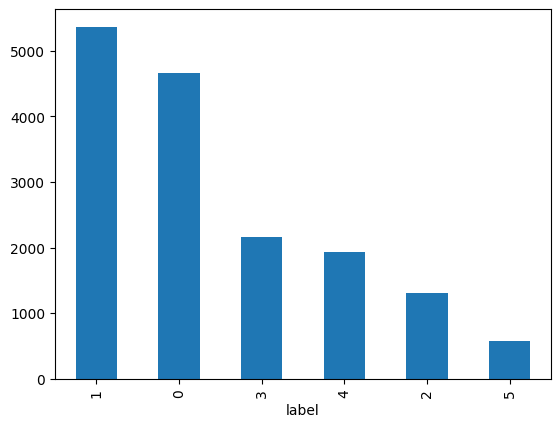

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [10]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())

The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [11]:
train_data.drop_duplicates(keep = 'first',inplace=True)

In [12]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())
print("Now the shape of the training dataset is ",train_data.shape)

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [13]:

nltk.download('stopwords')
pattern = re.compile('<.*?>')
punctuation = string.punctuation
ps = PorterStemmer()
tokenizer = Tokenizer()

def text_preprocess(text):

  text = re.sub(pattern,'',text)
  text = text.lower()
  text = text.translate(str.maketrans('','',punctuation))
  text = text.split()

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]
  return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]
processed_validation_data = [text_preprocess(words) for words in validation_data['text']]
processed_test_data = [text_preprocess(words) for words in test_data['text']]

In [15]:

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))


20360


In [16]:

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])

x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')
x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))

In [17]:

x_validation_sequences = []

for i in processed_validation_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(validation_data['label']))

In [18]:

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')
x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

In [19]:

vocab_size = 20360
dim = 50
sent_length = 50

In [20]:
bidirectional_lstm_model = Sequential()

# Define the input_shape in the *first* layer
bidirectional_lstm_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))

bidirectional_lstm_model.add(Bidirectional(LSTM(100)))
bidirectional_lstm_model.add(Dense(6, activation = 'softmax'))

bidirectional_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# The summary will now be fully populated
bidirectional_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │     1,018,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,140,006 (4.35 MB)

 Trainable params: 1,140,006 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4493 - loss: 1.3878 - val_accuracy: 0.8290 - val_loss: 0.4822
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8966 - loss: 0.2999 - val_accuracy: 0.8865 - val_loss: 0.3023
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9451 - loss: 0.1520 - val_accuracy: 0.8875 - val_loss: 0.3065
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9608 - loss: 0.0995 - val_accuracy: 0.8780 - val_loss: 0.3515
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9724 - loss: 0.0733 - val_accuracy: 0.8915 - val_loss: 0.3699


In [22]:
# --- LSTM model ---
print("\n--- Defining LSTM Model ---")
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(6,activation = 'softmax'))

lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()


--- Defining LSTM Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │     1,018,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,079,006 (4.12 MB)

 Trainable params: 1,079,006 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
lstm_model_history = lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3262 - loss: 1.5932 - val_accuracy: 0.3520 - val_loss: 1.5843
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3254 - loss: 1.5778 - val_accuracy: 0.3520 - val_loss: 1.5850
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3316 - loss: 1.5768 - val_accuracy: 0.3520 - val_loss: 1.5844
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3283 - loss: 1.5785 - val_accuracy: 0.3520 - val_loss: 1.5907
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3344 - loss: 1.5833 - val_accuracy: 0.2750 - val_loss: 1.5877


In [24]:
print("\n--- Defining Stacked LSTM Model ---")
stack_lstm_model = Sequential()
# Fix: Use input_shape to get a proper summary
stack_lstm_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))
stack_lstm_model.add(LSTM(100, return_sequences = True))
stack_lstm_model.add(LSTM(100, return_sequences = True))
stack_lstm_model.add(LSTM(50))
stack_lstm_model.add(Dense(6,activation = 'softmax'))

stack_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
stack_lstm_model.summary()


--- Defining Stacked LSTM Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 50)         │     1,018,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,189,306 (4.54 MB)

 Trainable params: 1,189,306 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
stack_lstm_model_history = stack_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3194 - loss: 1.6012 - val_accuracy: 0.3520 - val_loss: 1.5802
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3312 - loss: 1.5775 - val_accuracy: 0.3520 - val_loss: 1.5886
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3331 - loss: 1.5732 - val_accuracy: 0.3520 - val_loss: 1.5797
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3326 - loss: 1.5781 - val_accuracy: 0.3520 - val_loss: 1.5798
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3343 - loss: 1.5837 - val_accuracy: 0.3520 - val_loss: 1.5851


In [26]:
# --- GRU model ---
print("\n--- Defining GRU Model ---")
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))
gru_model.add(GRU(100))
gru_model.add(Dense(6,activation = 'softmax'))

gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
gru_model.summary()




--- Defining GRU Model ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 50)         │     1,018,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,064,206 (4.06 MB)

 Trainable params: 1,064,206 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
gru_model_history = gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3260 - loss: 1.5981 - val_accuracy: 0.3520 - val_loss: 1.5827
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3352 - loss: 1.5766 - val_accuracy: 0.3520 - val_loss: 1.5815
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3216 - loss: 1.5860 - val_accuracy: 0.3520 - val_loss: 1.5794
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3325 - loss: 1.5781 - val_accuracy: 0.3520 - val_loss: 1.5830
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3306 - loss: 1.5707 - val_accuracy: 0.3520 - val_loss: 1.5811


In [28]:
# --- Bidirectional GRU model ---
print("\n--- Defining Bidirectional GRU Model ---")
bidirectional_gru_model = Sequential()
bidirectional_gru_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))
bidirectional_gru_model.add(Bidirectional(GRU(100)))
bidirectional_gru_model.add(Dense(6,activation = 'softmax'))

bidirectional_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
bidirectional_gru_model.summary()




--- Defining Bidirectional GRU Model ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 50)         │     1,018,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,406 (4.24 MB)

 Trainable params: 1,110,406 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bidirectional_gru_model_history = bidirectional_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4761 - loss: 1.3364 - val_accuracy: 0.8505 - val_loss: 0.4052
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9076 - loss: 0.2582 - val_accuracy: 0.8935 - val_loss: 0.2830
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9470 - loss: 0.1450 - val_accuracy: 0.8830 - val_loss: 0.3172
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9610 - loss: 0.1046 - val_accuracy: 0.8865 - val_loss: 0.3405
Epoch 5/5
179/500 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9693 - loss: 0.0789

In [ ]:
print("\n--- Defining Stacked GRU Model ---")
stack_gru_model = Sequential()
stack_gru_model.add(Embedding(vocab_size, dim, input_shape=(sent_length,)))
stack_gru_model.add(GRU(100, return_sequences = True))
stack_gru_model.add(GRU(100, return_sequences = True))
stack_gru_model.add(GRU(50))
stack_gru_model.add(Dense(6,activation = 'softmax'))

stack_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
stack_gru_model.summary()


In [ ]:
stack_gru_model_history = stack_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

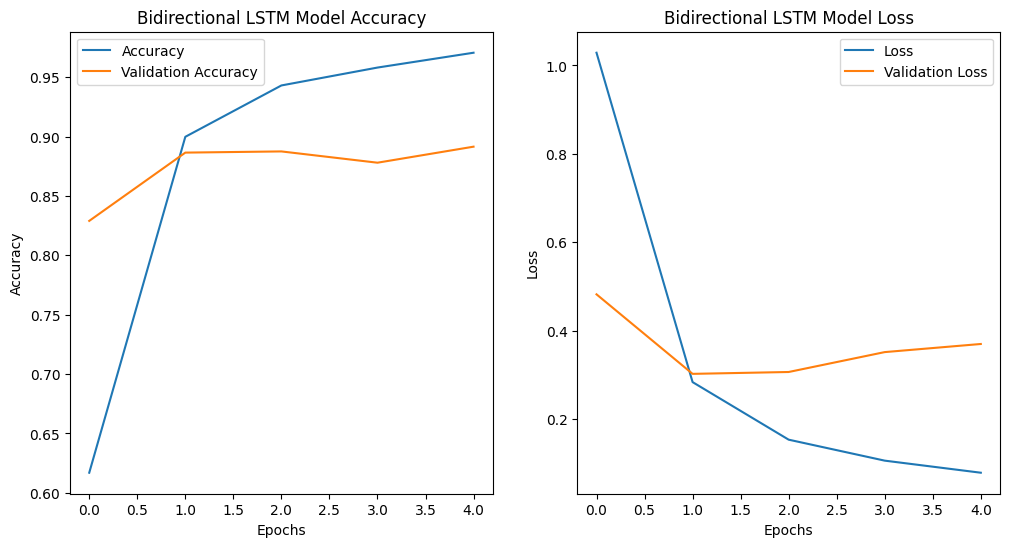

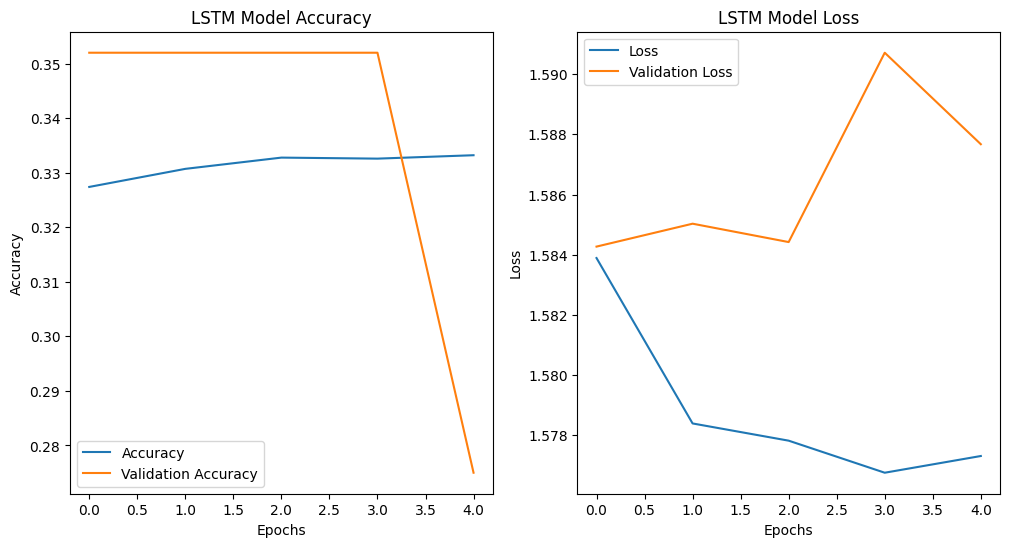

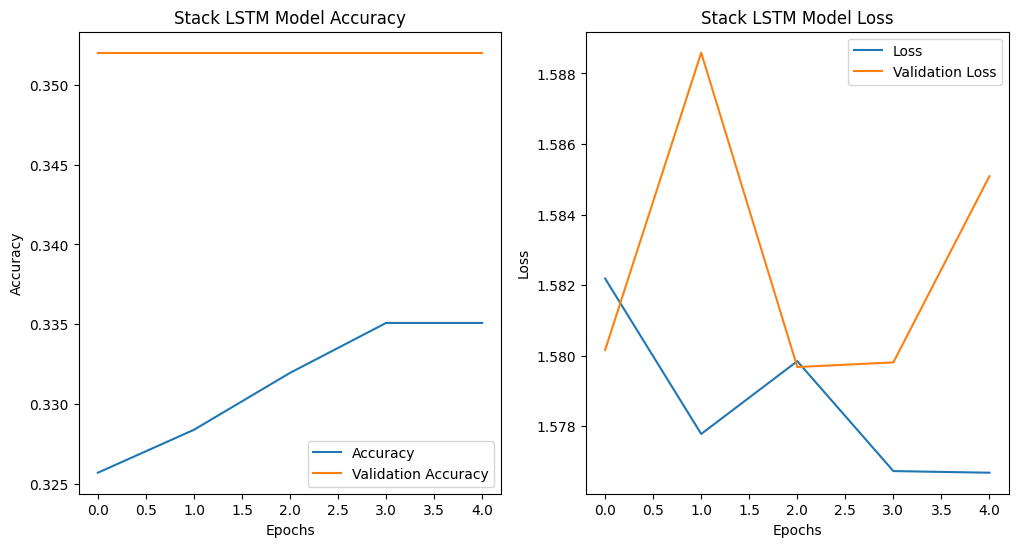

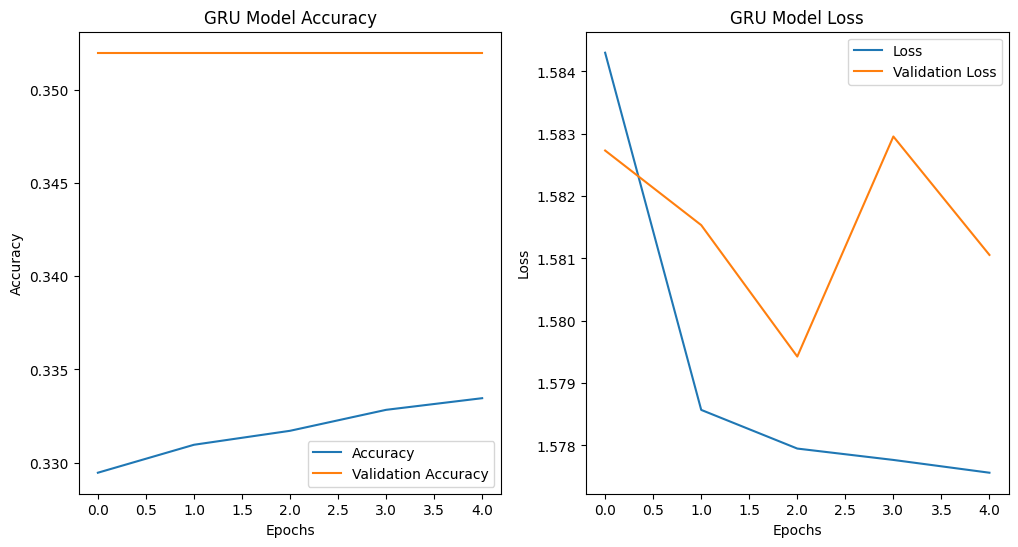

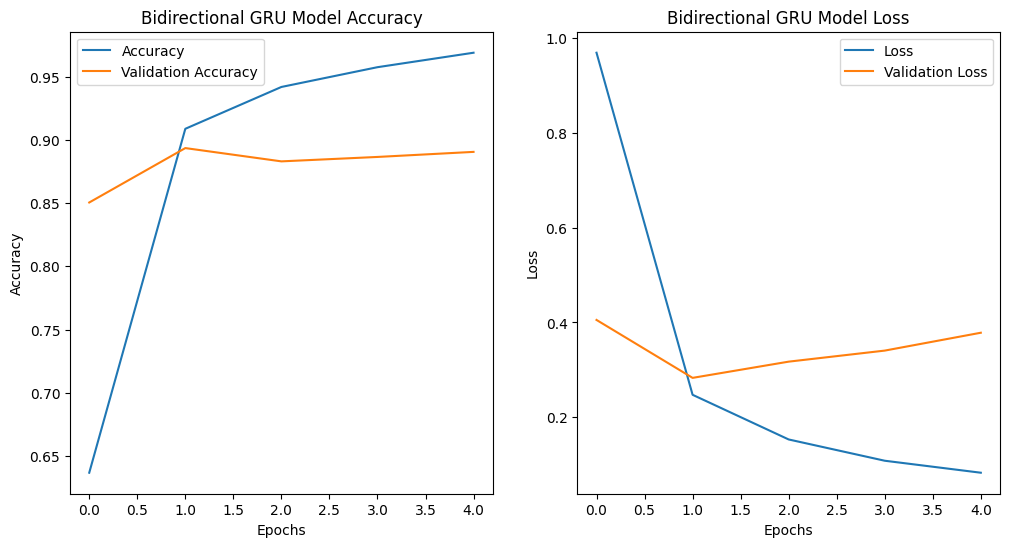

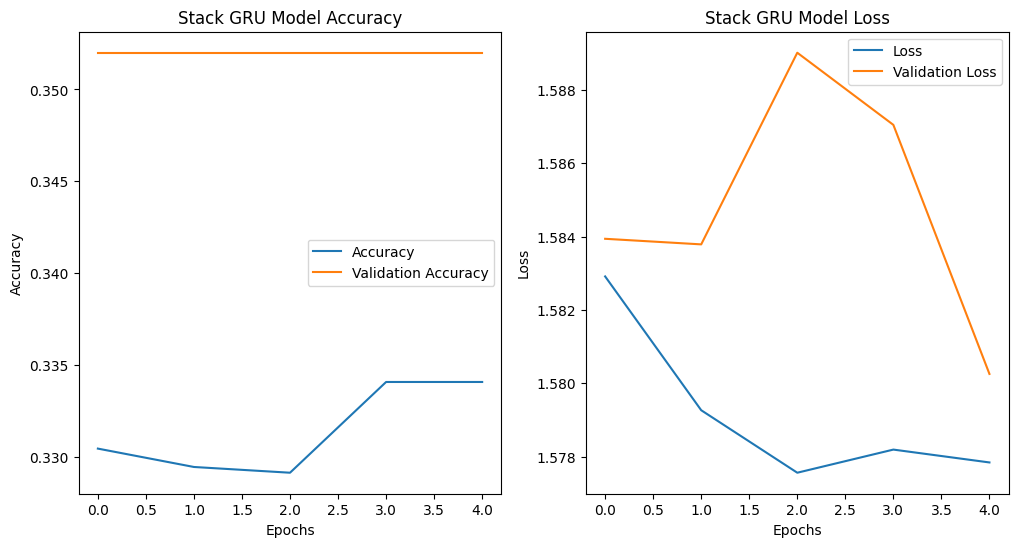

In [32]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(bidirectional_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model Loss")
plt.plot(bidirectional_lstm_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("LSTM Model Accuracy")
plt.plot(lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of LSTM model
plt.subplot(1,2,2)
plt.title("LSTM Model Loss")
plt.plot(lstm_model_history.history['loss'],label='Loss')
plt.plot(lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of Stack LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Stack LSTM Model Accuracy")
plt.plot(stack_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(stack_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Stack LSTM model
plt.subplot(1,2,2)
plt.title("Stack LSTM Model Loss")
plt.plot(stack_lstm_model_history.history['loss'],label='Loss')
plt.plot(stack_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("GRU Model Accuracy")
plt.plot(gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of GRU model
plt.subplot(1,2,2)
plt.title("GRU Model Loss")
plt.plot(gru_model_history.history['loss'],label='Loss')
plt.plot(gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of Bidirectional GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional GRU Model Accuracy")
plt.plot(bidirectional_gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Bidirectional GRU model
plt.subplot(1,2,2)
plt.title("Bidirectional GRU Model Loss")
plt.plot(bidirectional_gru_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting the accuracy plot of Stack GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Stack GRU Model Accuracy")
plt.plot(stack_gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(stack_gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Stack GRU model
plt.subplot(1,2,2)
plt.title("Stack GRU Model Loss")
plt.plot(stack_gru_model_history.history['loss'],label='Loss')
plt.plot(stack_gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
# Predicting the output of each model on test data for model evaluation
# ----------------------------------------------------------------------
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
y_pred_lstm = lstm_model.predict(x_test)
y_pred_stacklstm = stack_lstm_model.predict(x_test)
y_pred_bigru = bidirectional_gru_model.predict(x_test)
y_pred_gru = gru_model.predict(x_test)
y_pred_stackgru = stack_gru_model.predict(x_test)


# Converting the continuous output model into discrete classes
# ---------------------------------------------------------------------
y_pred_bilstm = np.array([np.argmax(x) for x in y_pred_bilstm])
y_pred_lstm = np.array([np.argmax(x) for x in y_pred_lstm])
y_pred_stacklstm = np.array([np.argmax(x) for x in y_pred_stacklstm])
y_pred_bigru = np.array([np.argmax(x) for x in y_pred_bigru])
y_pred_gru = np.array([np.argmax(x) for x in y_pred_gru])
y_pred_stackgru = np.array([np.argmax(x) for x in y_pred_stackgru])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [39]:
# Predicting the accuracy_score,f1_score,recall_score,precision_score of each model


result = {"Model Name":['Bidirectional LSTM',"LSTM","Stack LSTM", "Bidirectional GRU","GRU","Stack GRU"],
         "Accuracy Score":[accuracy_score(y_test,y_pred_bilstm),accuracy_score(y_test,y_pred_lstm),accuracy_score(y_test,y_pred_stacklstm),accuracy_score(y_test,y_pred_bigru),accuracy_score(y_test,y_pred_gru),accuracy_score(y_test,y_pred_stackgru)],
         "F1 Score(macro)":[f1_score(y_test,y_pred_bilstm,average='macro'),f1_score(y_test,y_pred_lstm,average='macro'),f1_score(y_test,y_pred_stacklstm,average='macro'),f1_score(y_test,y_pred_bigru,average='macro'),f1_score(y_test,y_pred_gru,average='macro'),f1_score(y_test,y_pred_stackgru,average='macro')],
         "Recall Score(macro)":[recall_score(y_test,y_pred_bilstm,average='macro'),recall_score(y_test,y_pred_lstm,average='macro'),recall_score(y_test,y_pred_stacklstm,average='macro'),recall_score(y_test,y_pred_bigru,average='macro'),recall_score(y_test,y_pred_gru,average='macro'),recall_score(y_test,y_pred_stackgru,average='macro')],
         "Precision Score(macro)":[precision_score(y_test,y_pred_bilstm,average='macro'),precision_score(y_test,y_pred_lstm,average='macro'),precision_score(y_test,y_pred_stacklstm,average='macro'),precision_score(y_test,y_pred_bigru,average='macro'),precision_score(y_test,y_pred_gru,average='macro'),precision_score(y_test,y_pred_stackgru,average='macro')],
         "F1 Score(micro)":[f1_score(y_test,y_pred_bilstm,average='micro'),f1_score(y_test,y_pred_lstm,average='micro'),f1_score(y_test,y_pred_stacklstm,average='micro'),f1_score(y_test,y_pred_bigru,average='micro'),f1_score(y_test,y_pred_gru,average='micro'),f1_score(y_test,y_pred_stackgru,average='micro')],
         "Recall Score(micro)":[recall_score(y_test,y_pred_bilstm,average='micro'),recall_score(y_test,y_pred_lstm,average='micro'),recall_score(y_test,y_pred_stacklstm,average='micro'),recall_score(y_test,y_pred_bigru,average='micro'),recall_score(y_test,y_pred_gru,average='micro'),recall_score(y_test,y_pred_stackgru,average='micro')],
         "Precision Score(micro)":[precision_score(y_test,y_pred_bilstm,average='micro'),precision_score(y_test,y_pred_lstm,average='micro'),precision_score(y_test,y_pred_stacklstm,average='micro'),precision_score(y_test,y_pred_bigru,average='micro'),precision_score(y_test,y_pred_gru,average='micro'),precision_score(y_test,y_pred_stackgru,average='micro')],}

result_df = pd.DataFrame(result)

result_df.to_excel("Report of Trained Model.xlsx")

display(result_df)

,Model Name,Accuracy Score,F1 Score(macro),Recall Score(macro),Precision Score(macro),F1 Score(micro),Recall Score(micro),Precision Score(micro)
0,Bidirectional LSTM,0.8800,0.826283,0.838622,0.816843,0.8800,0.8800,0.8800
1,LSTM,0.2905,0.075036,0.166667,0.048417,0.2905,0.2905,0.2905
2,Stack LSTM,0.3475,0.085962,0.166667,0.057917,0.3475,0.3475,0.3475
3,Bidirectional GRU,0.8850,0.845364,0.842669,0.851006,0.8850,0.8850,0.8850
4,GRU,0.3475,0.085962,0.166667,0.057917,0.3475,0.3475,0.3475
5,Stack GRU,0.3475,0.085962,0.166667,0.057917,0.3475,0.3475,0.3475


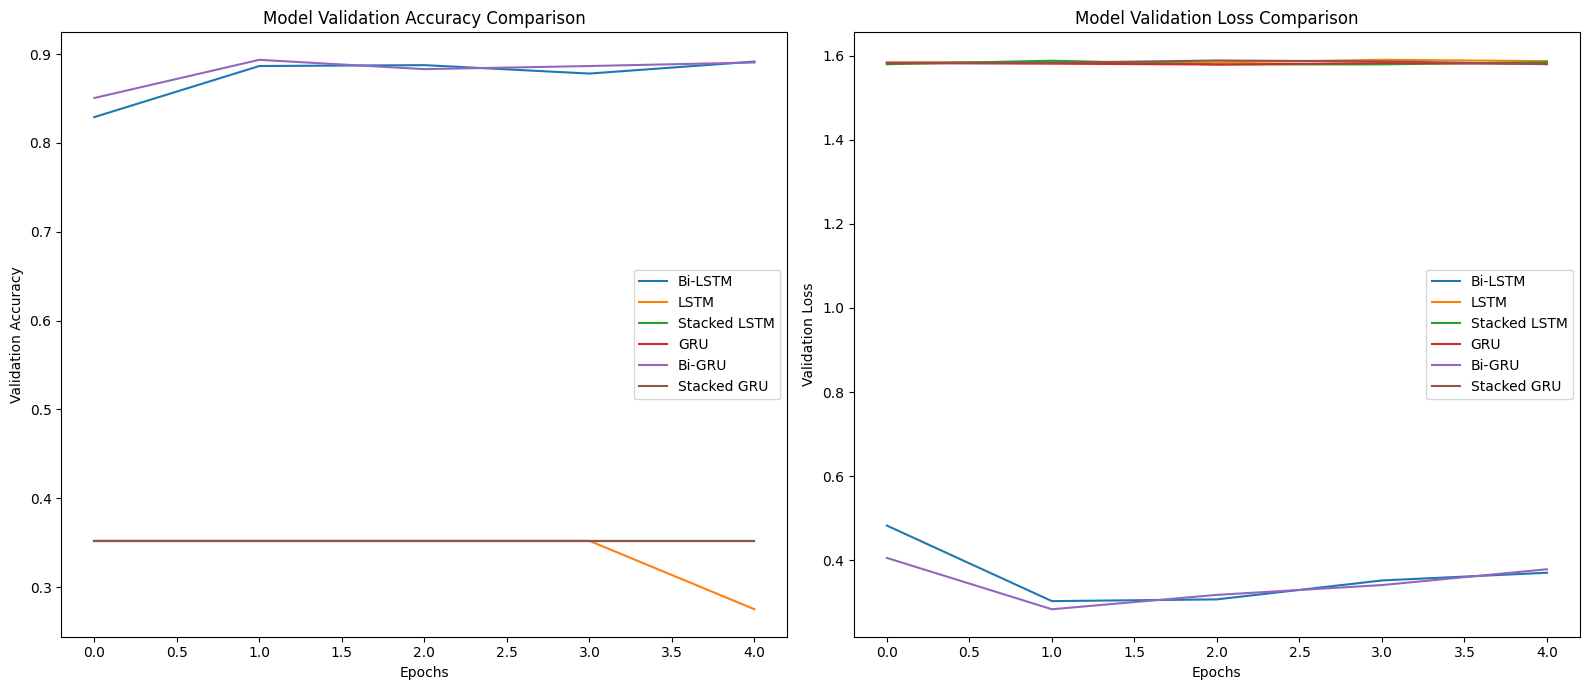

In [49]:
# Create a list of histories and their names
all_histories = {
    'Bi-LSTM': bidirectional_lstm_model_history,
    'LSTM': lstm_model_history,
    'Stacked LSTM': stack_lstm_model_history,
    'GRU': gru_model_history,
    'Bi-GRU': bidirectional_gru_model_history,
    'Stacked GRU': stack_gru_model_history
}

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.title("Model Validation Accuracy Comparison")

for model_name, history in all_histories.items():
    plt.plot(history.history['val_accuracy'], label=model_name)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.title("Model Validation Loss Comparison")

for model_name, history in all_histories.items():
    plt.plot(history.history['val_loss'], label=model_name)

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

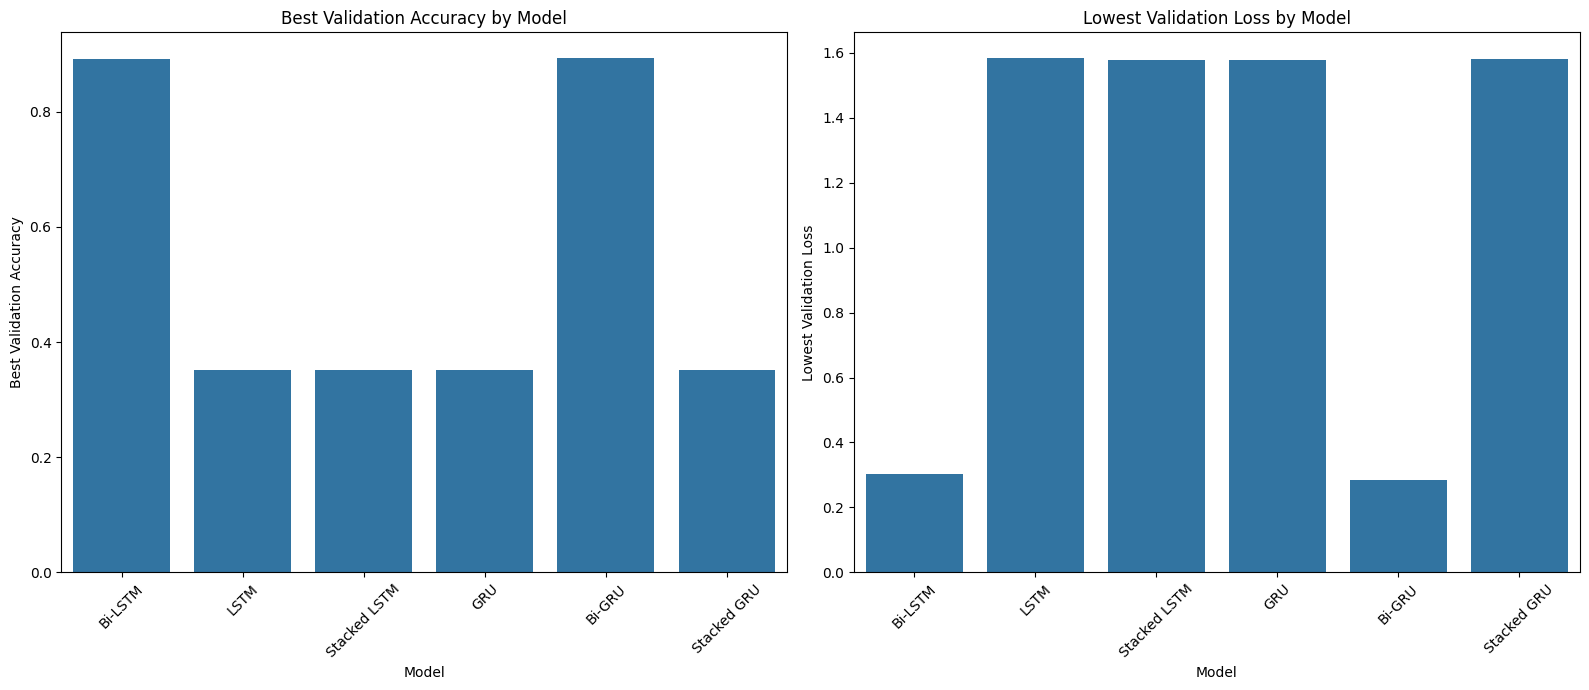

In [50]:
# Extract the best validation accuracy and lowest validation loss for each model
model_names = list(all_histories.keys())
best_val_acc = [max(h.history['val_accuracy']) for h in all_histories.values()]
lowest_val_loss = [min(h.history['val_loss']) for h in all_histories.values()]

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.title("Best Validation Accuracy by Model")
sns.barplot(x=model_names, y=best_val_acc)
plt.xlabel("Model")
plt.ylabel("Best Validation Accuracy")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.title("Lowest Validation Loss by Model")
sns.barplot(x=model_names, y=lowest_val_loss)
plt.xlabel("Model")
plt.ylabel("Lowest Validation Loss")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [53]:
# Making a predictive function which takes the input as text and in output it provide the emotion of the text

def predict_emotion_of_text(text):

    processed_text = text_preprocess(text)
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence],maxlen = 50, padding = 'post')

    prediction = bidirectional_gru_model.predict(padded_sequence)[0]

    classes = ['sadness','joy','love','anger','fear','surprise']


    print("Input: ",text)
    print("Output: ",classes[np.argmax(prediction)])
    print("\n")

In [48]:
predict_emotion_of_text("I got the job! I am absolutely ecstatic!")

predict_emotion_of_text("This is the third time my order has been wrong, I'm furious.")

predict_emotion_of_text("I feel so warm and happy when I'm with my family.")

predict_emotion_of_text("I've been feeling so down and empty all week.")

predict_emotion_of_text("I heard a strange noise downstairs, I'm too scared to look.")

predict_emotion_of_text("I can't believe he would do that to me.")

predict_emotion_of_text("The report is due by 5 PM on Friday.")

predict_emotion_of_text("I finally finished that difficult project, what a relief.")

predict_emotion_of_text("I hope my presentation goes well tomorrow.")

predict_emotion_of_text("He quit? Without any notice? I'm stunned.")

predict_emotion_of_text("Oh, great. Another meeting. Just what I needed today.")

predict_emotion_of_text("I'll miss you so much, but I'm happy you're following your dreams.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input:  I got the job! I am absolutely ecstatic!
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  This is the third time my order has been wrong, I'm furious.
Output:  anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  I feel so warm and happy when I'm with my family.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input:  I've been feeling so down and empty all week.
Output:  sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input:  I heard a strange noise downstairs, I'm too scared to look.
Output:  fear


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input:  I can't believe he would do that to me.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  The report is due by 5 PM on Friday.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input:  I finally finished that difficult project, what a relief.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input:  I hope my presentation goes well tomorrow.
Output:  joy


1/1 ━━━━

In [40]:
predict_emotion_of_text("I am absolutely furious about this, it's unacceptable!")
predict_emotion_of_text("He's so annoying, I wish he would just stop.")
predict_emotion_of_text("This is the last straw, I'm so frustrated.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input:  I am absolutely furious about this, it's unacceptable!
Output:  anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  He's so annoying, I wish he would just stop.
Output:  anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Input:  This is the last straw, I'm so frustrated.
Output:  anger




In [41]:
predict_emotion_of_text("I feel so lonely and miserable today.")
predict_emotion_of_text("My heart aches every time I think about it.")
predict_emotion_of_text("He left, and I've been crying all day.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  I feel so lonely and miserable today.
Output:  sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input:  My heart aches every time I think about it.
Output:  sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input:  He left, and I've been crying all day.
Output:  anger




In [42]:
predict_emotion_of_text("This is the best news I've heard all week!")
predict_emotion_of_text("I'm on top of the world, everything is perfect.")
predict_emotion_of_text("I'm so excited for the concert tonight.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Input:  This is the best news I've heard all week!
Output:  sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input:  I'm on top of the world, everything is perfect.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Input:  I'm so excited for the concert tonight.
Output:  joy




In [44]:
predict_emotion_of_text("I'm terrified of walking home alone in the dark.")
predict_emotion_of_text("My heart was pounding, I thought it was going to attack.")
predict_emotion_of_text("I'm really worried about the upcoming deadline.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Input:  I'm terrified of walking home alone in the dark.
Output:  fear


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input:  My heart was pounding, I thought it was going to attack.
Output:  fear


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Input:  I'm really worried about the upcoming deadline.
Output:  joy




In [45]:
predict_emotion_of_text("I can't believe you're actually here, what a shock!")
predict_emotion_of_text("I never saw that plot twist coming at all.")
predict_emotion_of_text("He just showed up at my door unannounced.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  I can't believe you're actually here, what a shock!
Output:  surprise


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input:  I never saw that plot twist coming at all.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Input:  He just showed up at my door unannounced.
Output:  anger




In [46]:
predict_emotion_of_text("I am so done with this.")
predict_emotion_of_text("I can't stop thinking about her.")
predict_emotion_of_text("I need to go to the grocery store later.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input:  I am so done with this.
Output:  anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input:  I can't stop thinking about her.
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Input:  I need to go to the grocery store later.
Output:  joy


